In [1]:
%load_ext autoreload
%autoreload 2

## Standard libraries
import os
import json
import math
import random
import pickle 

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
CUDA_LAUNCH_BLOCKING=1

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchvision import transforms as transforms

# our own modules
from model import get_model, load_model, test_model
from ATSDS import ATSDS

In [7]:
transform_train = transforms.Compose(
    [transforms.Resize(256),
    transforms.RandomCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

DATASET_PATH = os.path.join("data", "auswertung_hpc", "auswertung")
MODEL_NAME = "convnext_tiny"
XAI_NAME = "gradcam"
ADV_PCT = "10"
dataset_type = os.path.join("adversarial", ADV_PCT)
dataset_split = "test"
ROOT_PATH = os.path.join(DATASET_PATH, MODEL_NAME, XAI_NAME)

CHECKPOINT_PATH = "model/"
RANDOM_SEED = 1414

In [8]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Used for reproducability to fix randomness in some GPU calculations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)

Using device cpu
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\adversarial\10\test


In [9]:
#xai_methods = ["gradcam","ig_fixpoints","lime","prism","xrai"]
xai_methods = ["gradcam"]
performance_xai_type = {}
# ctiny_versions = ["standard","test","test_BN","test_NOSD"]
# model_names = ["simple_cnn","vgg16","resnet50","convnext_tiny"]
model_names = ["convnext_tiny"]


In [ ]:

for model_name in model_names:
    # Initialize model, loss, optimizer, and learning rate scheduler
    model = get_model(model_name=model_name, n_classes=testset.get_num_classes())
    model = model.to(device)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)
    
    # Load model checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_PATH, f"{model_name}_1_1.tar")
    epoch, trainstats = load_model(model, optimizer, scheduler, checkpoint_path)
    
    for current_method in xai_methods:
        # Construct the root path for the current method and model
        ROOT_PATH = os.path.join(DATASET_PATH, model_name, current_method)

        # Initialize lists to store metrics
        c_list, c_5_list, softmaxes_list, scores_list, losses = [], [], [], [], []

        # Iterate over adversarial perturbation levels
        for pct in range(0, 101, 10):
            dataset_type = os.path.join("adversarial", str(pct))
            testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
            testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)

            # Test the model and collect metrics
            c, c_5, t, loss, softmaxes, scores = test_model(model, testloader, loss_criterion, device)
            c_list.append(c); c_5_list.append(c_5); softmaxes_list.append(softmaxes); scores_list.append(scores)

        
        # Store performance metrics for the current model and XAI method
        performance_xai_type[model_name] = (c_list, c_5_list, softmaxes_list, scores_list, losses)

    # Store the total evaluation time or metric
    total = t


In [12]:
# Save the performance_xai_type dictionary to a pickle file
dic_save_path = os.path.join(DATASET_PATH, MODEL_NAME, "adv_results.pkl")
with open(dic_save_path, 'wb') as f:
    pickle.dump(performance_xai_type, f)


In [13]:
# Load the performance_xai_type dictionary from the pickle file
dic_load_path = os.path.join(DATASET_PATH, MODEL_NAME, "adv_results.pkl")
with open(dic_load_path, 'rb') as f:
    performance_xai_type1 = pickle.load(f)

In [14]:
print(performance_xai_type1)
accuracies = []
for current_method in model_names:
    correct,correct_5,softmax,score,loss = performance_xai_type1[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies.append(accuracy)

{'convnext_tiny': ([array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 20,  6,  0,  0,  3,  0,  0,
        1, 17], dtype=int64), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 20,  6,  0,  0,  3,  0,  0,
        1, 19], dtype=int64), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 21,  6,  0,  2,  3,  0,  1,
        2, 19], dtype=int64), array([ 0,  0,  0,  0,  0,  0,  1,  0,  0,  1, 21,  6,  1,  6,  3,  0,  1,
        2, 20], dtype=int64), array([ 0,  0,  0,  1,  2,  1,  2,  1,  4,  1, 20,  6,  4, 14,  3,  0,  1,
        3, 24], dtype=int64), array([ 0,  0,  0,  4,  2,  2,  3,  1,  9,  1, 21,  6,  6, 17,  3,  0,  1,
        3, 26], dtype=int64), array([ 0,  0,  0,  6,  5,  2,  8,  1, 17,  1, 22,  6, 10, 23,  3,  0,  1,
        4, 27], dtype=int64), array([ 0,  0,  1, 12,  6,  3, 10,  1, 19,  1, 22,  6, 12, 24,  4,  0,  1,
        8, 26], dtype=int64), array([ 1,  0,  2, 14,  8,  3, 13,  1, 21,  1, 22,  6, 13, 25,  4,  0,  1,
        9, 27], dtype=int64), array([ 2,  0,  2, 17, 12,  6, 15, 

In [15]:
# for entry in accuracies_all[0]:
for entry in accuracies:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title(MODEL_NAME)
plt.show()

In [ ]:
tiny_versions_display = ["ConvNeXt-T", "No Layerscale", "Batchnorm instead of Layernorm", "No Stochastic Depth"]
for i,entry in enumerate(accuracies):
    plt.plot(entry)
plt.legend(ctiny_versions_display,loc=2)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])
plt.xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])


In [42]:
print(accuracies)

[]


In [17]:
print(xai_methods)

['gradcam', 'ig_fixpoints', 'lime', 'prism', 'xrai']


In [ ]:
# performance_xai_resnet = pickle.load(open(DATASET_PATH + "resnet50" + "adv_results.pkl", 'rb'))
performance_xai_convnext_tiny = pickle.load(open(DATASET_PATH + "convnext_tiny" + "adv_results.pkl", 'rb'))
performance_xai_simple_cnn = pickle.load(open(DATASET_PATH + "simple_cnn" + "adv_results.pkl", 'rb'))
# performance_xai_vgg16 = pickle.load(open(DATASET_PATH + "vgg16" + "adv_results.pkl", 'rb'))
# perf_tables = [performance_xai_simple_cnn,performance_xai_vgg16,performance_xai_resnet,performance_xai_convnext_tiny]
perf_tables = [performance_xai_simple_cnn, performance_xai_convnext_tiny]

In [ ]:
accuracies_all = []
for performance_xai_type in perf_tables:
    accuracies = []
    for current_method in xai_methods:
        print(current_method)
        correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
        accuracy = np.mean((np.divide(correct,50)),axis=1)
        accuracies.append(accuracy)
    accuracies_all.append(accuracies)

In [ ]:
for entry in accuracies_all[1]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('VGG16')
plt.show()
print(accuracies_all[1])

In [ ]:
for entry in accuracies_all[2]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('ResNet')
plt.show()

In [30]:
for entry in accuracies_all[3]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('ConvNext')
plt.show()

In [31]:
print([x for x in accuracies_all[3]])

[array([0.05157895, 0.05263158, 0.05684211, 0.06736842, 0.09052632,
       0.11052632, 0.14421053, 0.16421053, 0.18      , 0.20105263,
       0.21684211]), array([0.05157895, 0.07684211, 0.30210526, 0.67789474, 0.82526316,
       0.88736842, 0.90631579, 0.92526316, 0.94210526, 0.95052632,
       0.95578947]), array([0.05157895, 0.07263158, 0.15578947, 0.35578947, 0.51894737,
       0.67789474, 0.76210526, 0.83578947, 0.87789474, 0.91157895,
       0.92105263]), array([0.05157895, 0.05473684, 0.06842105, 0.07894737, 0.08842105,
       0.10947368, 0.12210526, 0.13578947, 0.15052632, 0.16631579,
       0.18842105]), array([0.05157895, 0.08105263, 0.30105263, 0.65368421, 0.82210526,
       0.86842105, 0.89684211, 0.91157895, 0.91473684, 0.93263158,
       0.93263158])]


In [36]:
correct,correct_5,softmax,score,loss = performance_xai_convnext_tiny


In [121]:
prism_acc = np.divide(performance_xai_convnext_tiny["prism"][0],50)
gradcam_acc = np.divide(performance_xai_convnext_tiny["gradcam"][0],50)

In [135]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(prism_acc.T):
    ax[0].plot(i)
for index,i in enumerate(gradcam_acc.T):
    ax[1].plot(i)
    
ax[0].set_ylim(ymin=0,ymax=1)

ax[0].set_title("ConvNeXt - PRISM - Classwise Accuracies")
ax[1].set_title("ConvNeXt - GradCAM - Classwise Accuracies")

Text(0.5, 1.0, 'ConvNeXt - GradCAM - Classwise Accuracies')

In [80]:
im1 = Image.open("data/auswertung/resnet50/ig_fixpoints/test/00011/mask_on_image/000466.png")
im2 = Image.open("data/auswertung/resnet50/xrai/test/00010/mask_on_image/000444.png")

In [84]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(xrai_acc.T):
    ax[0].imshow(im2)
for index,i in enumerate(igf_acc.T):
    ax[1].imshow(im1)
ax[0].set_title("ResNet - XRAI")
ax[1].set_title("ResNet - IGF")

Text(0.5, 1.0, 'ResNet - IGF')

In [114]:
im1 = np.load("data/auswertung/convnext_tiny/prism/test/00005/mask/000229.png.npy")
im2 = np.load("data/auswertung/convnext_tiny/gradcam/test/00012/grad_mask/000519.png.npy")
im1_raw = Image.open("data/atsds_large/test/00005/000229.png")
im2_raw = Image.open("data/atsds_large/test/00012/000519.png")

Text(0.5, 1.0, 'ConvNeXt - GradCAM')

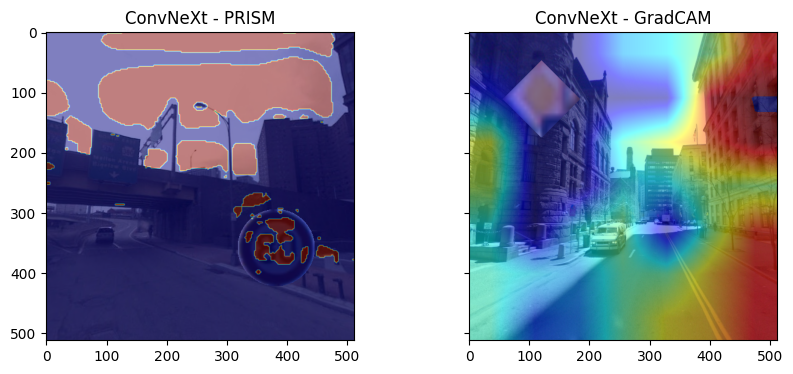

In [115]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(xrai_acc.T):
    ax[0].imshow(mask_on_image(im1,normalize_image(np.array(im1_raw))))
for index,i in enumerate(igf_acc.T):
    ax[1].imshow(mask_on_image(im2,normalize_image(np.array(im2_raw))))
ax[0].set_title("ConvNeXt - PRISM")
ax[1].set_title("ConvNeXt - GradCAM")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from torchvision import transforms

transform_test = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

import cv2
def mask_on_image(mask,img,alpha=0.5):
    heatmap = get_rgb_heatmap(mask)
    img = img
    cam_on_img = (1-alpha)*img + alpha*heatmap
    return np.copy(cam_on_img)

def get_rgb_heatmap(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return np.copy(heatmap)
def normalize_image(img):
    return np.nan_to_num((img-img.min())/(img.max()-img.min()), nan=0.0, posinf=0.0,neginf=0.0)


In [9]:
with open(DATASET_PATH + "IGF_optimized_parameters.pkl", 'rb') as f:
    optimized_performance = pickle.load(f)
with open(DATASET_PATH + "IGF_initial_parameters.pkl", 'rb') as f:
    initial_performance = pickle.load(f)


In [10]:
print(optimized_performance)

{'simple_cnn': ([array([ 0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  8, 17,  0,  0,  0, 29,  1,
        0,  0], dtype=int64), array([ 1,  2,  0,  0,  1,  6,  2,  0,  0,  2, 15, 24,  0,  0,  2, 31,  2,
        0,  4], dtype=int64), array([ 3,  8, 15,  3, 16, 30, 21,  7, 11,  7, 18, 33,  0,  6, 12, 34, 10,
        9, 18], dtype=int64), array([ 9, 16, 21,  8, 22, 32, 36, 16, 33,  8, 20, 35,  1, 12, 13, 35, 11,
       14, 21], dtype=int64), array([12, 22, 22,  8, 28, 33, 39, 19, 38, 12, 22, 35,  1, 14, 13, 35, 11,
       14, 22], dtype=int64), array([13, 24, 24, 12, 29, 34, 40, 19, 41, 13, 23, 36,  3, 16, 13, 35, 12,
       14, 25], dtype=int64), array([14, 27, 26, 12, 30, 35, 40, 23, 44, 17, 23, 38,  4, 16, 15, 35, 12,
       14, 25], dtype=int64), array([17, 27, 29, 14, 32, 38, 40, 23, 44, 20, 23, 38,  5, 18, 17, 38, 13,
       18, 25], dtype=int64), array([20, 29, 30, 17, 32, 39, 40, 25, 44, 21, 23, 38,  5, 18, 18, 38, 16,
       19, 26], dtype=int64), array([20, 29, 30, 17, 33, 39, 40, 27,

In [11]:
print(initial_performance)

{'simple_cnn': ([array([ 0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  8, 16,  0,  0,  0, 30,  1,
        0,  0], dtype=int64), array([ 0,  2,  0,  0,  0,  4,  1,  0,  0,  1, 12, 22,  0,  0,  1, 31,  1,
        0,  5], dtype=int64), array([ 4,  8, 15,  3, 15, 30, 21,  7, 11,  6, 17, 29,  2,  9, 11, 35,  9,
       10, 19], dtype=int64), array([11, 15, 21,  9, 24, 34, 37, 18, 38,  9, 17, 34,  2, 14, 13, 35, 12,
       14, 22], dtype=int64), array([13, 20, 22, 10, 27, 33, 40, 19, 41, 10, 18, 34,  3, 15, 14, 35, 12,
       15, 22], dtype=int64), array([12, 22, 22, 11, 29, 36, 38, 20, 41, 12, 18, 35,  3, 17, 14, 35, 12,
       17, 23], dtype=int64), array([12, 24, 23, 13, 32, 35, 39, 23, 41, 12, 19, 36,  3, 17, 15, 36, 12,
       17, 25], dtype=int64), array([14, 26, 25, 13, 32, 38, 41, 24, 44, 13, 20, 37,  4, 18, 15, 36, 12,
       18, 25], dtype=int64), array([17, 26, 27, 15, 34, 38, 41, 24, 44, 14, 24, 38,  4, 20, 16, 37, 12,
       18, 25], dtype=int64), array([19, 28, 27, 15, 34, 38, 41, 24,

In [12]:
accuracies_init = []
accuracies_optim = []
for current_method in model_names:
    correct,correct_5,softmax,score,loss = initial_performance[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies_init.append(accuracy)
    correct,correct_5,softmax,score,loss = optimized_performance[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies_optim.append(accuracy)

In [13]:
print(accuracies_init)
print(accuracies_optim)

[array([0.06105263, 0.08421053, 0.27473684, 0.39894737, 0.42421053,
       0.43894737, 0.45684211, 0.47894737, 0.49894737, 0.51052632,
       0.52736842]), array([0.05263158, 0.14631579, 0.72      , 0.95578947, 0.97368421,
       0.98315789, 0.98947368, 0.98947368, 0.99157895, 0.99157895,
       0.99157895]), array([0.05157895, 0.07368421, 0.16947368, 0.34421053, 0.39052632,
       0.42315789, 0.44      , 0.47263158, 0.48210526, 0.49578947,
       0.50631579]), array([0.05157895, 0.07684211, 0.30210526, 0.67789474, 0.82526316,
       0.88736842, 0.90631579, 0.92526316, 0.94210526, 0.95052632,
       0.95578947])]
[array([0.06105263, 0.09684211, 0.27473684, 0.38210526, 0.42105263,
       0.44842105, 0.47368421, 0.50421053, 0.52421053, 0.54315789,
       0.56631579]), array([0.05263158, 0.16315789, 0.69157895, 0.93263158, 0.96      ,
       0.97789474, 0.98315789, 0.98631579, 0.98736842, 0.98736842,
       0.99052632]), array([0.05263158, 0.07157895, 0.15368421, 0.29684211, 0.36736842,
 

In [21]:
model_names_display = ["Simple CNN","VGG16","ResNet50","ConvNeXt-T"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8),dpi=800,sharey=True)

# Plot each element of the array in a separate subplot
for i, value in enumerate(accuracies_init):
    row = i // 2
    col = i % 2
    axs[row, col].plot(accuracies_init[i])
    axs[row, col].plot(accuracies_optim[i])
    axs[row, col].set_title(model_names_display[i])
    axs[row, col].set_xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])
    axs[row, col].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])

plt.tight_layout()
axs[0, 1].legend(["Initial Parameters","Optimized Parameters"])
fig.text(0.5,0.0,"Revealed Percentage", ha = 'center')
fig.text(0.0,0.5,"Test-Accuracy", ha = 'center', rotation='vertical')


Text(0.0, 0.5, 'Test-Accuracy')